In [64]:
cd /content/drive/MyDrive/2021/HandsOnMachineLearning/main

/content/drive/MyDrive/2021/HandsOnMachineLearning/main


**3.1 MNIST**

In [65]:
# MNIST 데이터 내려받기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [66]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


- mnist["data"]: 70,000개의 이미지에 각 784개의 특성 (28x28 픽셀 이미지)

- mnist["target"]: 각 data 이미지가 나타내는 숫자

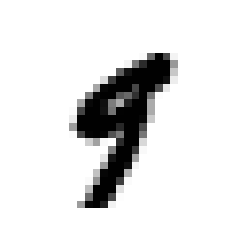

In [122]:
# 예시 이미지 출력
import matplotlib
import matplotlib.pyplot as plt


some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) # 28x28 픽셀 이미지

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

In [123]:
y[36000]

'9'

In [69]:
# train set, test set 분리
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [70]:
# shuffle train set
import numpy as np

shuffled_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffled_index], y_train[shuffled_index]

**3.2 이진 분류기 훈련**

In [71]:
# 숫자 5인지 여부 구분하는 이진 분류기
y_train_5 = (y_train == '5') # 9는 True, 나머지는 False
y_test_5 = (y_test == '5')

In [72]:
# 확률적 경사 하강법 (SGD)
from sklearn.linear_model import SGDClassifier

# 숫자 5에 대한 SGD 학습
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [73]:
sgd_clf.predict([some_digit])

array([False])

**3.3 성능 측정**

In [74]:
# 3.3.1 교차검증을 사용한 정확도 측정
# K-fold validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.94805, 0.96505, 0.95225])

In [75]:
# 5가 아닌 이미지에 대한 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    pass
  
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [76]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91005, 0.90995, 0.90895])

In [77]:
# 3.3.2 오차 행렬
# 예측값 생성
from sklearn.model_selection import cross_val_predict

# k-fold cross validataion으로 예측
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [78]:
# confusion_matrix() 함수를 사용해서 오차 행렬 생성
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53707,   872],
       [ 1821,  3600]])

In [ ]:
# 오차 행렬
[[TN, FP],
 [FN, TP]]

In [79]:
# 3.3.3 정밀도와 재현율
from sklearn.metrics import precision_score, recall_score

# 실제 train set label과 예측값 비교 -> 정밀도(precision), 재현율(recall) 계산
print('정밀도', precision_score(y_train_5, y_train_pred))
print('재현율', recall_score(y_train_5, y_train_pred))

정밀도 0.8050089445438283
재현율 0.6640841173215274


In [81]:
# f1 score 계산
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7277873243707672

In [85]:
# 결정함수, desicion function 임곗값 확인
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = -200000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-161786.29838037]
[ True]


threshold가 예측 점수보다 낮으므로 some_digit의 예측값은 True를 반환한다.

In [87]:
# 임곗값 변경
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [88]:
# 적절한 임곗값을 구하는 방법

# 1. cross_val_predict()로 모든 샘플의 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [94]:
# 2. 정밀도와 재현율 계산
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

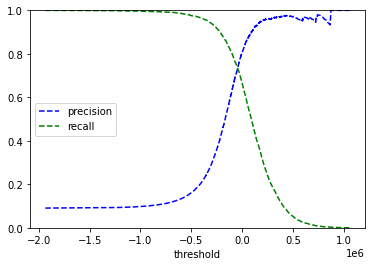

In [97]:
# 3. matplotlib을 통해 정밀도와 재현율 그래프 그리기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="recall")
  plt.xlabel("threshold")
  plt.legend(loc="center left")
  plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [98]:
# threshold를 70000으로 했을 때 예측
y_train_pred_90 = (y_scores > 70000)
print('precision: ', precision_score(y_train_5, y_train_pred_90))
print('recall: ', recall_score(y_train_5, y_train_pred_90))

precision:  0.8831604636973764
recall:  0.5340343110127282


In [99]:
# 3.3.5 ROC 곡선
# ROC 곡선은 민감도에 대한 '1 - 특이도' 그래프
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

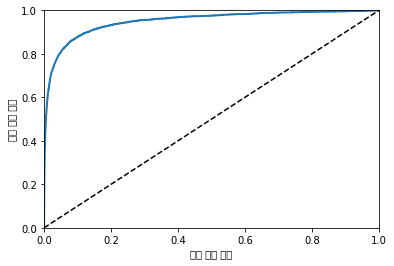

In [101]:
# ROC 곡서 그래프
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('거짓 양성 비율')
  plt.ylabel('진짜 양성 비율')

plot_roc_curve(fpr, tpr)
plt.show()

# ROC 곡선
- 재현율이 높을수록 분류기가 만드는 거짓 양성이 늘어난다.
- 점선: 완전한 랜덤 분류기의 ROC 곡선
- 좋은 분류기는 점선에서 최대한 멀리 떨어져 있어야한다.
- AUC(곡전 아래의 면적)을 측정하여 분류기 비교 가능.

In [102]:
# AUC 계산
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))

0.9502988445110624


In [103]:
# RandomForestClassifier 모델을 훈련하여 비교
# RandomForestClassifier는 predict_proba() 메서드를 통해 클래스 결정
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51667 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50984 missing from current font.
  font.set_

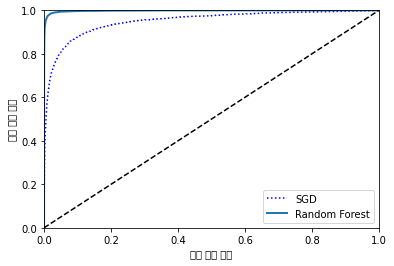

In [105]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

random forest가 SGD보다 더 좋은 성능을 보인다.

In [106]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982683248646085

**3.4 다중 분류**

In [110]:
# SGDClassifier의 다중 분류 확인
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array(['4'], dtype='<U1')

In [111]:
# 10개 클래스 전체에 대해서 점수가 계산되어짐
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores)

[[-754380.0012084  -403403.4526193  -628317.24288108 -310088.36565089
    28287.78147772 -184991.16526326 -839981.64231954 -501254.3397878
  -313716.23325898 -251475.78926193]]


In [118]:
maxIdx = np.argmax(some_digit_scores)
print(sgd_clf.classes_)
print(sgd_clf.classes_[maxIdx])

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
4


In [125]:
# OneVsOneClassifier - SGDClassifier 사용 예제
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
len(ovo_clf.estimators_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

['4']


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


45

In [127]:
# RandomForestClassifier
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array(['9'], dtype=object)

In [128]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.01, 0.  , 0.01, 0.07, 0.01, 0.  , 0.01, 0.  , 0.89]])

In [130]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.88585, 0.8686 , 0.8606 ])

In [132]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.9091 , 0.91125, 0.9057 ])